In [1]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt

In [2]:
#Initialize some parameters

BETA = np.array([.5,.5])
MU = np.array([.5,.5])
THETA = np.array([.5, .5])
LIST = 1.
COST = 1.

In [3]:
def calc_price(theta,cost): 
    """compute each insurer's price"""
    theta1, theta2 = theta
    p1 = (2.*theta1+theta2)/3. + cost
    p2 = (2.*theta2+theta1)/3. + cost
    return np.array((p1,p2))
  
    
def calc_t(theta,cost):
    """compute the proportion of people choosing each insurer"""
    p1,p2 = calc_price(theta,cost)
    t1 = .5 + (p2 - p1)/(2.*cost)
    t1 = max(0.,min(1.,t1)) #insure t1 in the require range
    return np.array( [t1, (1-t1)] )


def calc_profits(theta,cost):
    """compute profits for each firm"""
    p = calc_price(theta,cost)
    t = calc_t(theta,cost)
    return t*(p-theta)


def outside_option(theta,cost,list_price):
    """compute each firms outside option (i.e. list price)"""
    outside1 =  np.array((list_price,theta[1]))
    outside2 =  np.array((theta[0],list_price))
    
    no_deal1 = calc_profits(outside1 ,cost)
    no_deal2 = calc_profits(outside2 ,cost)
    
    return np.array([no_deal1[0], no_deal2[1]])    


def nash_barganing(theta,cost,list_price,beta,mu):
    """compute the nash bargaining objective for both firms"""
    #print 'initial theta: %s'%theta
    theta = np.minimum(theta,list_price)
    profits = calc_profits(theta,cost)
    hosp_profit = np.tile((mu*theta).sum(),2)
    no_deal = outside_option(theta,cost,list_price)
    return (profits -  no_deal)**beta * hosp_profit**(1-beta)

In [4]:
def simult_obj(theta,cost,list_price,beta,mu):
    """simultaneous objective (both together)"""
    theta[1] = theta[0]
    return -nash_barganing(theta,cost,list_price,beta,mu)[0]


def simult_bargain(theta_init,cost,list_price,beta,mu):
    result = minimize(simult_obj, theta_init , args=(cost,list_price,beta,mu), method='Nelder-Mead', 
         options={'disp': False})
    return np.minimum(result.x,list_price)

In [5]:
def seq_obj(theta,cost,list_price,beta,mu,stage):
    """objective function depends on the period
    
    Specifically, based on the choice of theta1, we must minimize to get theta2"""
    if stage == 0:
        return - nash_barganing(theta,cost,list_price,beta,mu)[stage]
    if stage == 1:
        h = minimize(seq_obj, theta, args=(cost,list_price,beta,mu,0), method='Nelder-Mead', 
                         options={'disp': False})
        theta[1] = h.x[1] #leave theta0 fixed
        return  -nash_barganing(theta,cost,list_price,beta,mu)[stage]


def seq_bargain(theta,cost,list_price,beta,mu):
    result = minimize(seq_obj, theta, args=(cost,list_price,beta,mu,0), method='Nelder-Mead', 
                         options={'disp': False})
    #do not fulfill loop invariant
    return np.minimum(result.x,list_price)

In [6]:
def setup_grid(min_arg, max_arg, no_step):
    """set up grid for numerical approximation"""
    grid = np.array(range(no_step))
    
    #multi_dimensial paramters
    if type(min_arg) == np.ndarray:
        grid = grid.reshape(len(grid),1)
        grid = np.tile(grid,(1,2))
    
    scale = (max_arg-min_arg)/(no_step-1)
    grid = grid*scale+min_arg
    return grid

In [7]:
def make_row(theta,g,cost,mu):
    """setup a row in the table"""
    
    if type(g) == np.ndarray:
        g = g[0] #only focus on first entry
        
    g_col = np.array([g])
    profit = calc_profits(theta,cost)
    hosp = np.array([(mu*theta).sum()])
    row = np.concatenate((g_col,theta,profit,hosp))
    return row


def make_table(arg_no, min_arg, max_arg, no_step, 
               params = [THETA, COST, LIST, BETA, MU] ):
    """make tables for write up"""
    
    params = params[:] #running into trouble with global variables
    grid = setup_grid(min_arg, max_arg, no_step )
    table = []
    
    for g in grid:
        params[arg_no] = g
        theta,cost,list_price,beta,mu = params
        
        #calculate simult bargain outcome
        theta_simult = simult_bargain(theta,cost,list_price,beta,mu)
        row_simult = make_row(theta_simult,g,cost,mu)
        table.append(row_simult)
        
        #calculate sequential outcome
        theta_seq = seq_bargain(theta,cost,list_price,beta,mu)
        row_seq = make_row(theta_seq,g,cost,mu)
        table.append(row_seq)
    return np.array(table)


def write_table(fname, table):
    """write table to file in a pretty way"""
    f = open(fname, "w+")
    for i in range(len(table)):
        row = tuple(table[i])
        
        #set row label
        label = 'Simultaneous,'
        if i%2 == 1: label = 'First Mover,'
            
        pretty_row = label +'%.3f,%.3f,%.3f,%.3f,%.3f,%.3f \n'%tuple(row)
        f.write(pretty_row)        
    f.close()

In [8]:
#reinitialize parameters
BETA = np.array([.5,.5])
MU = np.array([.5,.5])
THETA = np.array([.5, .5])
LIST = 1.
COST = 1.

#list price
list_table = make_table(2, 1., 6., 11)
write_table('sheets/table_l.csv', list_table)
    
#lambda
costs_table = make_table(1, 1., 6., 11)
write_table('sheets/table_lambda.csv', costs_table)

#illness probability
ill_table = make_table(4,np.array([.1,.5]), np.array([1.,.5]), 10)
write_table('sheets/table_mu.csv', ill_table)

In [9]:
#hard code column names (for purposes of creating indexes)
COLNAMES = ['','Simultaneous', 'Simultaneous',
            'Simultaneous', 'Simultaneous','Simultaneous', 
            '','First Mover', 'Second Mover',
            'First Mover', 'Second Mover','First Mover']


def plot_table(table,labels,indexes):
    """quick code for graphing things"""
    length, width = table.shape
    table_plot = table.reshape(length/2,width*2)
    title = '%s vs %s'%labels
    
    #set up labels
    fig = plt.figure()
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    for i in indexes:
        plt.plot(table_plot[:,0],table_plot[:,i],label=COLNAMES[i])
    plt.legend()
    
    #set up file names
    fname = 'plots/%s'%(title)
    fname = ( fname.replace(' ', '_') ).lower()
    fig.savefig(fname)

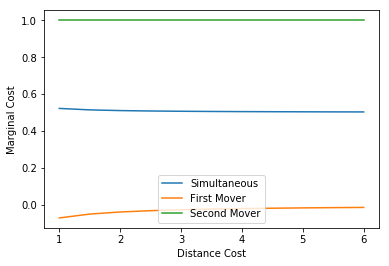

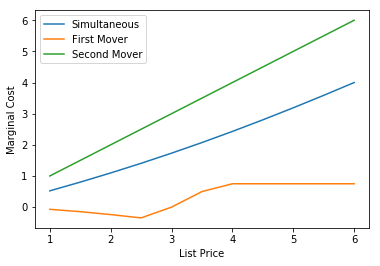

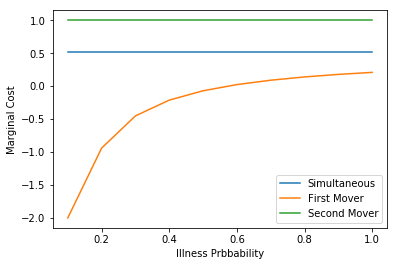

In [10]:
#plotting various theta's
plot_table(costs_table, ('Distance Cost','Marginal Cost'), [1,7,8])
plot_table(list_table, ('List Price','Marginal Cost'),[1,7,8])
plot_table(ill_table, ('Illness Prbbability','Marginal Cost'),[1,7,8])

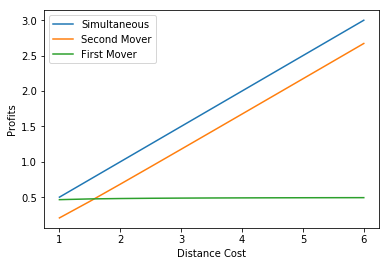

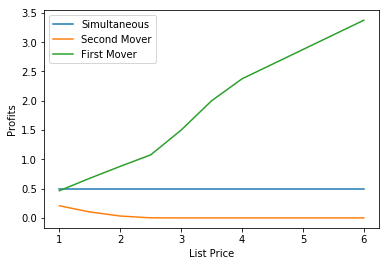

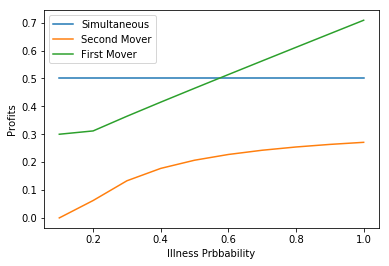

In [11]:
#plotting various pi's
plot_table(costs_table, ('Distance Cost','Profits'), [4,10,11])
plot_table(list_table, ('List Price','Profits'),[4,10,11])
plot_table(ill_table, ('Illness Prbbability','Profits'),[4,10,11])

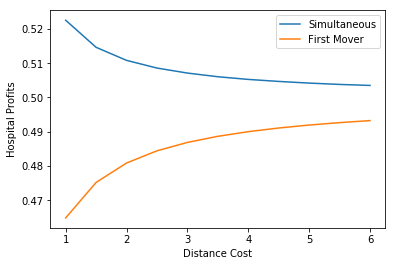

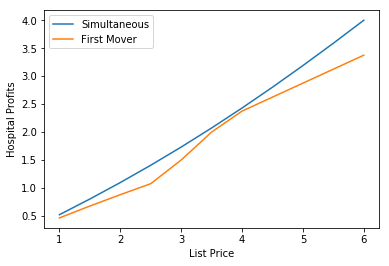

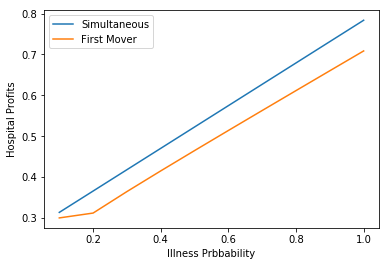

In [12]:
#hospital profits

plot_table(costs_table, ('Distance Cost','Hospital Profits'), [5,11])
plot_table(list_table, ('List Price','Hospital Profits'),[5,11])
plot_table(ill_table, ('Illness Prbbability','Hospital Profits'),[5,11])